# Contents
- [1. Data loading/cleaning](#1)
- [2. Exploratory Data Analisys](#2)
- [2.1 Time Series Decomposition](#2.1)
- [2.2 Outliers](#2.2)
- [3. Feature engineering](#3)
- [3.1 Trend changepoints](#3.1)
- [3.2 Lag Features](#3.2)
- [4. Forecasting Model](#4)
- [4.1 Pipeline](#4.1)
- [4.2 Linear Regression](#4.2)
- [4.3 Recursive forecasting](#4.3)

<a name = '1'></a>
# 1. Data loading/cleaning

In [1]:
# Data cleaning - wrangling
import pandas as pd
import numpy as np

# Timer series decomposition
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.impute import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import clone, make_pipeline, make_union

# Model -> building / performance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Settings
from sklearn import set_config
set_config(transform_output = 'pandas')
plt.style.use('seaborn-v0_8-dark-palette')

In [2]:
# Loaging data
file = 'datos temperatura.xlsx'
raw = pd.read_excel(file)

raw.head()

Date Temperature (S-THB 20809178:20800294-1), *C, iagro_1
0  03-29-23 11:00:00                                              24,12  
1  03-29-23 11:30:00                                              24,80  
2  03-29-23 12:00:00                                              21,65  
3  03-29-23 12:30:00                                              22,92  
4  03-29-23 13:00:00                                              24,29

In [3]:
def tweak_weather(df):
    """
    Returns a clean temperature dataframe
    df: 'datos temperatura.xlsx' dataframe with columns 'Date' and 'Temperature (S-THB 20809178:20800294-1)'
    
    Output (Dataframe):
    - Set Date column to datetime in pandas,
    - Adjust 'Temperature (S-THB 20809178:20800294-1), *C, iagro_1' column 
        with temperatures as float (Temperature column)
    - Create month, week, day, day_of_week, hour, minute columns to do EDA on dataset
    - Sort values by Date
    - Set datetime index on dataframe
    """
    return(df
           .assign(
               Date = pd.to_datetime(df.Date),
               Temperature = df['Temperature (S-THB 20809178:20800294-1), *C, iagro_1'].str.replace(',', '.').astype('float'),
               month = lambda df_: df_.Date.dt.month.astype('int'),
               week = lambda df_: df_.Date.dt.isocalendar().week.astype('int'),
               day = lambda df_: df_.Date.dt.day.astype('int'),
               day_of_week = lambda df_: df_.Date.dt.dayofweek.astype('int'),
               hour = lambda df_: df_.Date.dt.hour.astype('int'),
               minute = lambda df_: df_.Date.dt.minute.astype('int'),
               
           )
           .drop(columns = ['Temperature (S-THB 20809178:20800294-1), *C, iagro_1'])
           .sort_values('Date')
           .set_index('Date', drop = True)
    )


weather = tweak_weather(raw)
weather.head()

Temperature  month  week  day  day_of_week  hour  minute
Date                                                                         
2023-03-29 11:00:00        24.12      3    13   29            2    11       0
2023-03-29 11:30:00        24.80      3    13   29            2    11      30
2023-03-29 12:00:00        21.65      3    13   29            2    12       0
2023-03-29 12:30:00        22.92      3    13   29            2    12      30
2023-03-29 13:00:00        24.29      3    13   29            2    13       0

In [4]:
# NAN values
weather.isna().sum()

Temperature    0
month          0
week           0
day            0
day_of_week    0
hour           0
minute         0
dtype: int64

In [5]:
# Dataframe descriptive statistics
weather.Temperature.describe()

count    8633.000000
mean       15.491447
std         5.359684
min         0.160000
25%        11.730000
50%        15.510000
75%        18.980000
max        32.610000
Name: Temperature, dtype: float64

<a name = '2'></a>
# 2. Exploratory Data Analisys
- There is a daily seasonality
- There is not a weekly or monthly seasonality in the data, we can see a pattern (mainly on the weekly seasonality plot) due to the daily seasonality.

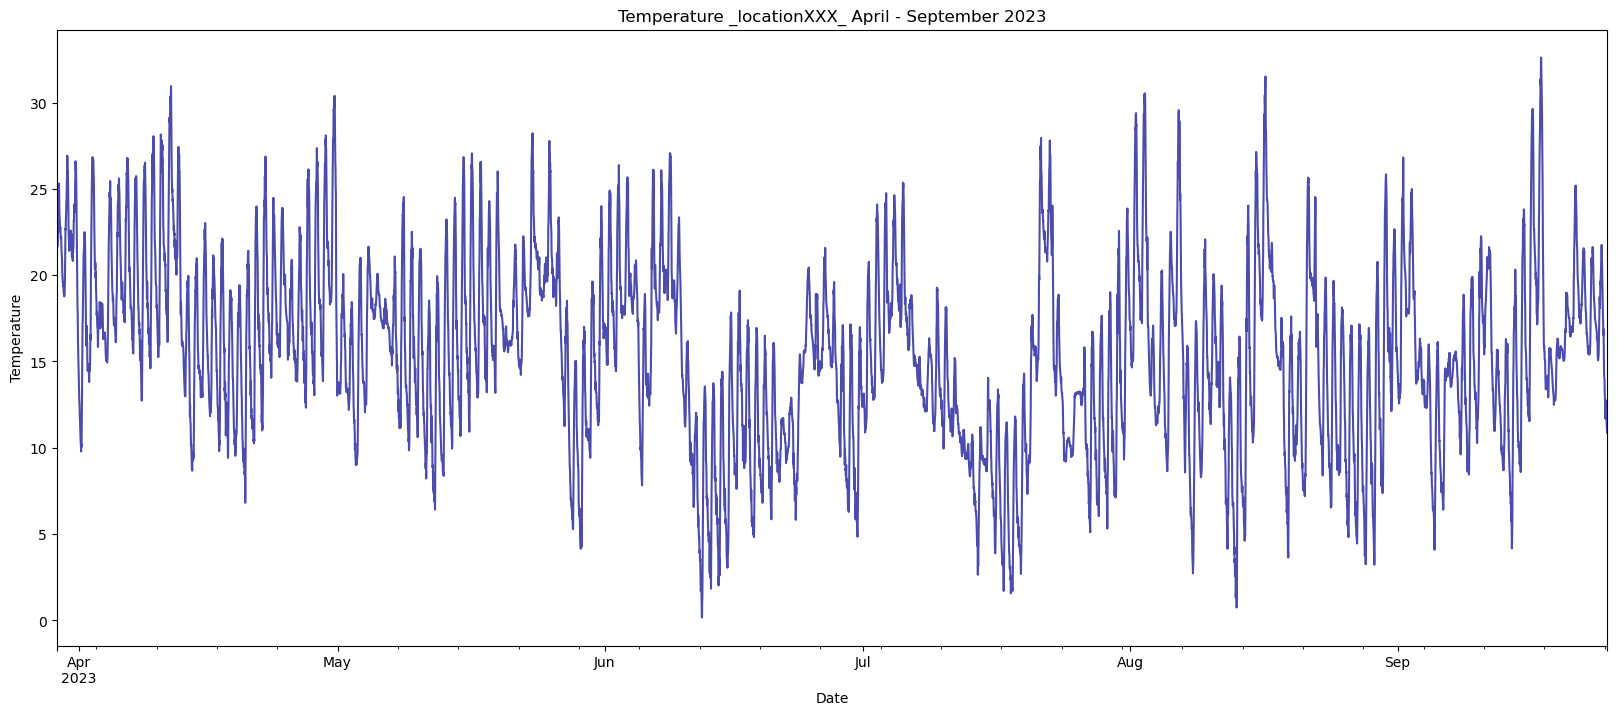

In [6]:
# Plotting Temperature time series
weather.Temperature.plot(color = 'darkblue', figsize = (20, 8), legend = False, alpha = 0.7)

plt.ylabel('Temperature')
plt.title('Temperature _locationXXX_ April - September 2023')
plt.show()

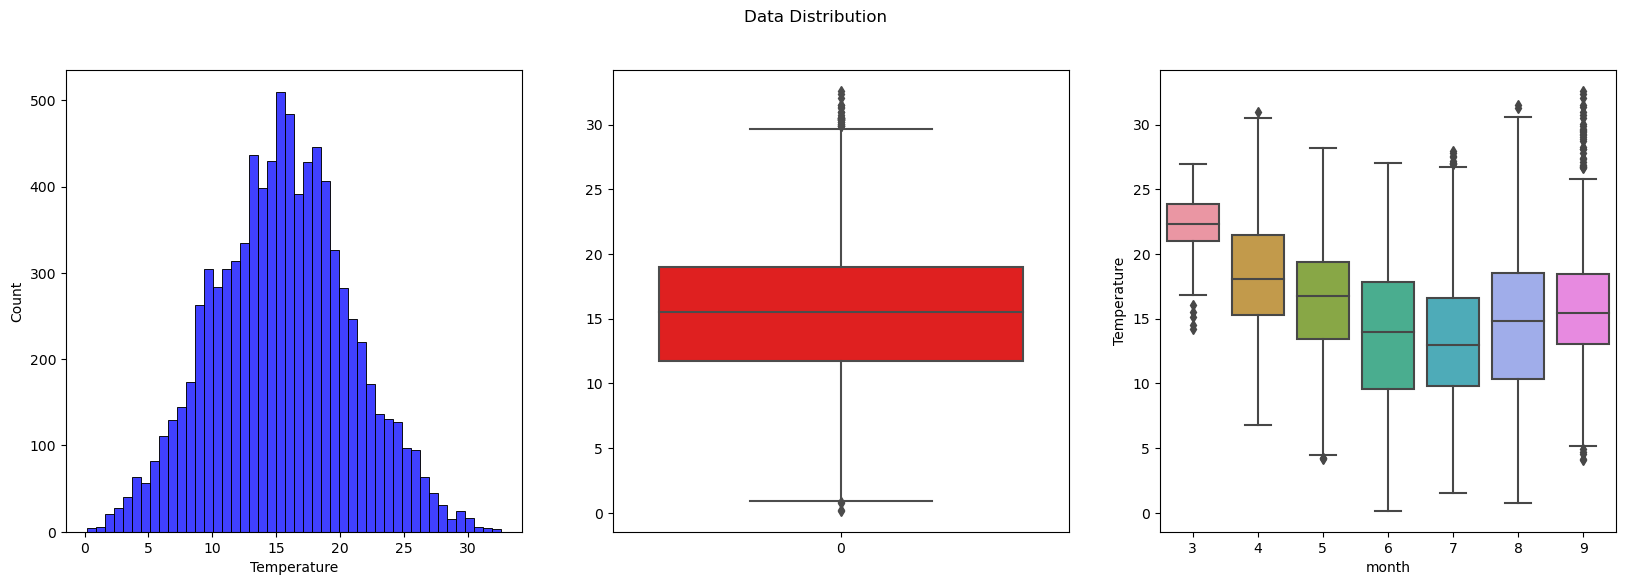

In [7]:
# Data distribution
fig, ax = plt.subplots(figsize = (20, 6), ncols = 3)

sns.histplot(weather.Temperature, color = 'b', ax = ax[0])
sns.boxplot(weather.Temperature, color = 'r', ax = ax[1])
sns.boxplot(x = weather.month, y = weather.Temperature, ax = ax[2])

fig.suptitle('Data Distribution')

plt.show()

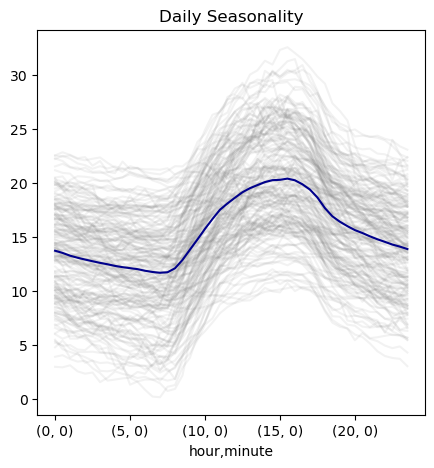

In [8]:
# Daily seasonality
fig, ax = plt.subplots(figsize = (5, 5))

(weather
 .pivot_table(index = ['hour', 'minute'], columns = ['month', 'day'], values = 'Temperature')
 .plot(color = 'gray', legend = False, alpha = 0.1, ax = ax))

(weather
 .pivot_table(index = ['hour', 'minute'], aggfunc = 'mean', values = 'Temperature')
 .plot(color = 'darkblue', legend = False, ax = ax))

ax.set_title('Daily Seasonality')
plt.show()

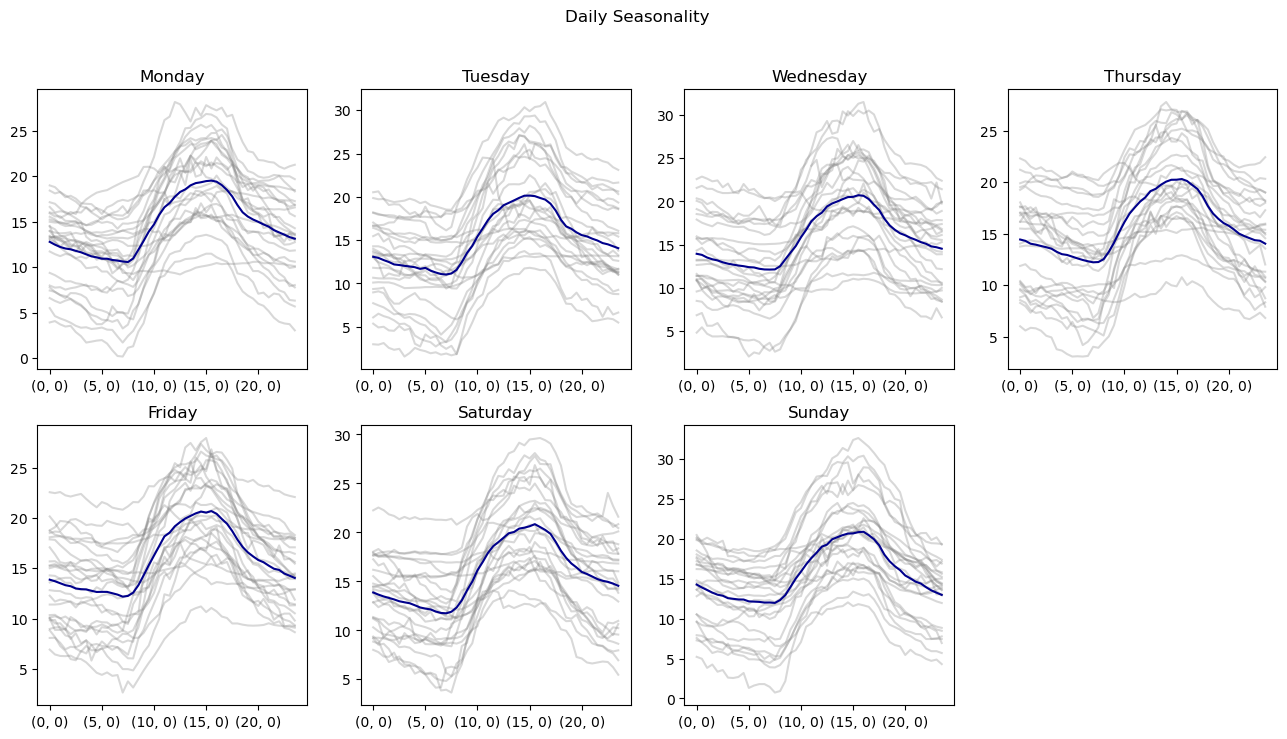

In [9]:
# Daily seasonality
fig, ax = plt.subplots(ncols = 4, nrows = 2)

dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, ix in enumerate(ax.flatten()):
    
    if i > 6 :
        ix.remove()
        break
    
    (weather
     .loc[weather.day_of_week == i]
     .pivot_table(index = ['hour', 'minute'], columns = ['month', 'day'], values = 'Temperature')
     .plot(color = 'gray', legend = False, alpha = 0.3, figsize = (16, 8), ax = ix)
    )
    
    (weather
     .loc[weather.day_of_week == i]
     .pivot_table(index = ['hour', 'minute'], columns = ['day_of_week'], aggfunc = 'mean', values = 'Temperature')
     .plot(color = 'darkblue', legend = False, ax = ix)
    )
    
    ix.set_title(dow[i])
    ix.set_xlabel('')

fig.suptitle('Daily Seasonality')
plt.show()

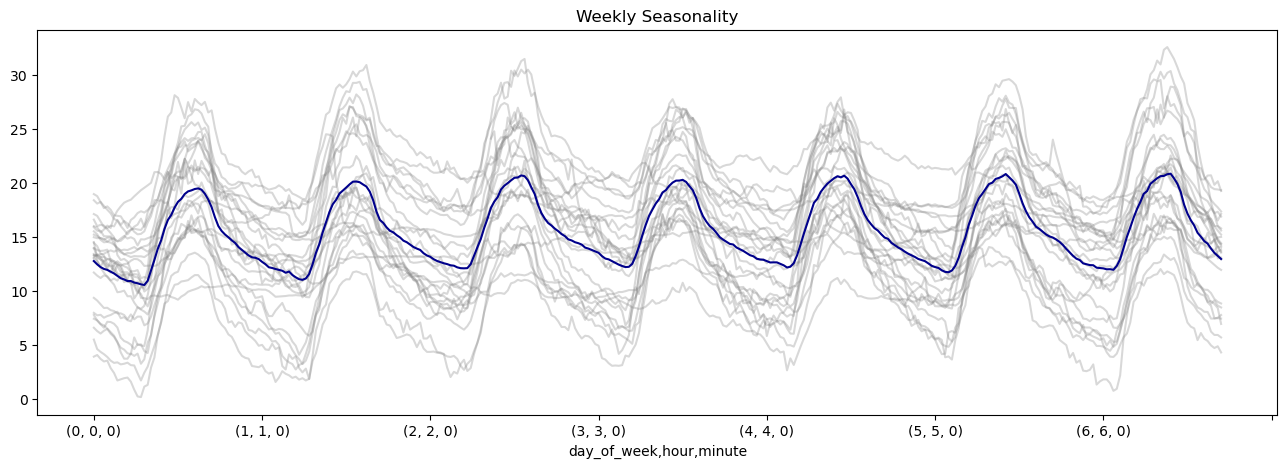

In [10]:
# Weekly seasonality
fig, ax = plt.subplots(figsize = (16, 5))

(weather
 .pivot_table(index = ['day_of_week', 'hour', 'minute'], columns = ['week'], values = 'Temperature')
 .plot(color = 'gray', legend = False, alpha = 0.3, ax = ax)
)

(weather
 .pivot_table(index = ['day_of_week','hour', 'minute'], aggfunc = 'mean', values = 'Temperature')
 .plot(color = 'darkblue', legend = False, ax = ax)
)

ax.set_title('Weekly Seasonality')
plt.show()

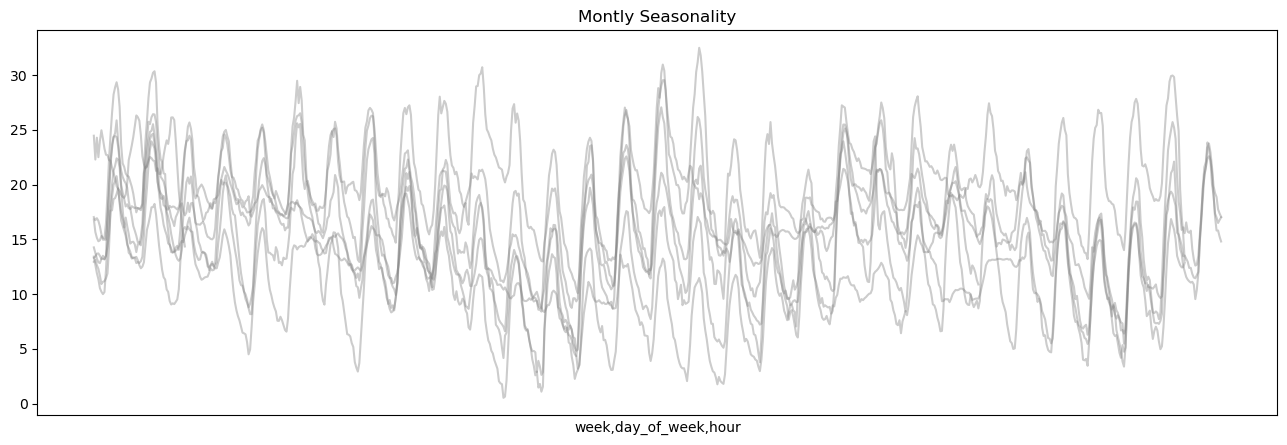

In [11]:
# Montly seasonality
fig, ax = plt.subplots(figsize = (16, 5))

for m in sorted(weather.month.unique()):
    (weather
     .loc[weather.month == m]
     .pivot_table(index = ['week', 'day_of_week', 'hour'], columns = ['month'], values = 'Temperature')
     .plot(color = 'gray', legend = False, alpha = 0.4, ax = ax)
    )

ax.set_xticks([])

ax.set_title('Montly Seasonality')
plt.show()

<a name = '2.1'></a>
## 2.1 Time Series Decomposition
The time series will be decomposed taking into account:
- Daily seasonality
- Trend on the entire dataset

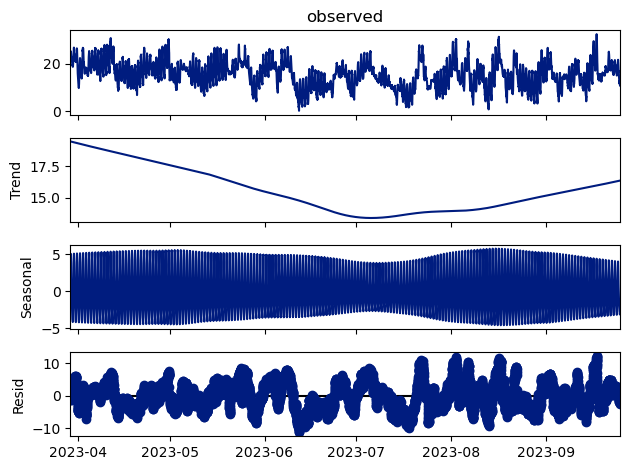

In [12]:
# Time series decomposition
dec = MSTL(weather.Temperature, 
           periods = (48), # Daily seasonality
           windows = (49), 
           iterate = 3, 
           stl_kwargs={
               "trend" : int(len(weather)/2) + 1,
           }
          ).fit()

dec.plot();

<a name = '2.2'></a>
## 2.2 Outliers
According to the EDA process we can conclude there are outliers on the data on august (2nd, 16th) and september (17th), in this case the data was real, therefore there is no need to imputate or remove them from the dataset.

In [13]:
def set_changepoints(df):
    """
    Create a boolean change points columnn in a dataframe
    df: Dataframe with a trend column after decomposition
    
    Output (Dataframe):
    - Same dataframe with trend changepoints column where True = changepoint
    """
    df = (df
          .assign(
              lwr_gtr = lambda df_:np.where(df_.trend < df_.trend.shift(1), 'decrease', 'increase'),
              changepoint = lambda df_: (df_.lwr_gtr.ne(df_.lwr_gtr.shift(1))),)
          .drop(columns = 'lwr_gtr')
         )
    df.iloc[1, -1] = False
    
    return df

def highligth_outliers(df, alpha = 1.5):
    """
    Returns a dataframe with highlight outliers
    df: Clean Temperatude datetime index dataframe with column 'Temperature'
    alpha: Rate to compute upper and lower boundaries
    
    Output (Dataframe):
    - Compute Interquantile Range,
    - Use time series decomposition to create resid column (residuals) 
        and seasons_trend column (series without residuals)
    - Create upper and lower columns with thresholds
    - is_outlier column with outliers marked as True
    """
    
    df = df[['Temperature']].copy()
    
    Q1 = dec.resid.quantile(.25)
    Q3 = dec.resid.quantile(.75)
    IQR = Q3 - Q1
    
    return(df
           .assign(
               lower = Q1 - (alpha * IQR),
               upper = Q3 + (alpha * IQR),
               resid = dec.resid,
               trend = dec.trend,
               seasons_trend = dec.trend + dec.seasonal,
               is_outlier = lambda df_: np.where((df_.resid > df_.upper)|(df_.resid < df_.lower), True, False),
           )
           .pipe(set_changepoints)
    )

w_outliers = highligth_outliers(weather)
w_outliers.sample(10)

Temperature      lower      upper     resid      trend  \
Date                                                                          
2023-08-24 02:30:00         9.06 -11.623226  11.050923 -2.478660  14.747855   
2023-04-20 14:00:00        20.39 -11.623226  11.050923 -2.733380  18.167218   
2023-05-09 13:00:00        21.44 -11.623226  11.050923 -0.096319  17.073029   
2023-06-24 21:30:00        17.61 -11.623226  11.050923  4.422907  13.763183   
2023-09-06 15:00:00        14.27 -11.623226  11.050923 -5.901232  15.421961   
2023-05-21 20:30:00        16.80 -11.623226  11.050923  0.882107  16.208291   
2023-07-08 03:00:00        12.24 -11.623226  11.050923  0.808175  13.396330   
2023-04-28 15:00:00        26.74 -11.623226  11.050923  3.711772  17.709291   
2023-05-13 17:30:00        21.22 -11.623226  11.050923  1.183163  16.840548   
2023-05-20 03:00:00        17.34 -11.623226  11.050923  3.812249  16.346508   

                     seasons_trend  is_outlier  changepoint  
Date                                                         
2023-08-24 02:30:00      11.538660       False        False  
2023-04-20 14:00:00      23.123380       False        False  
2023-05-09 13:00:00      21.536319       False        False  
2023-06-24 21:30:00      13.187093       False        False  
2023-09-06 15:00:00      20.171232       False        False  
2023-05-21 20:30:00      15.917893       False        False  
2023-07-08 03:00:00      11.431825       False        False  
2023-04-28 15:00:00      23.028228       False        False  
2023-05-13 17:30:00      20.036837       False        False  
2023-05-20 03:00:00      13.527751       False        False

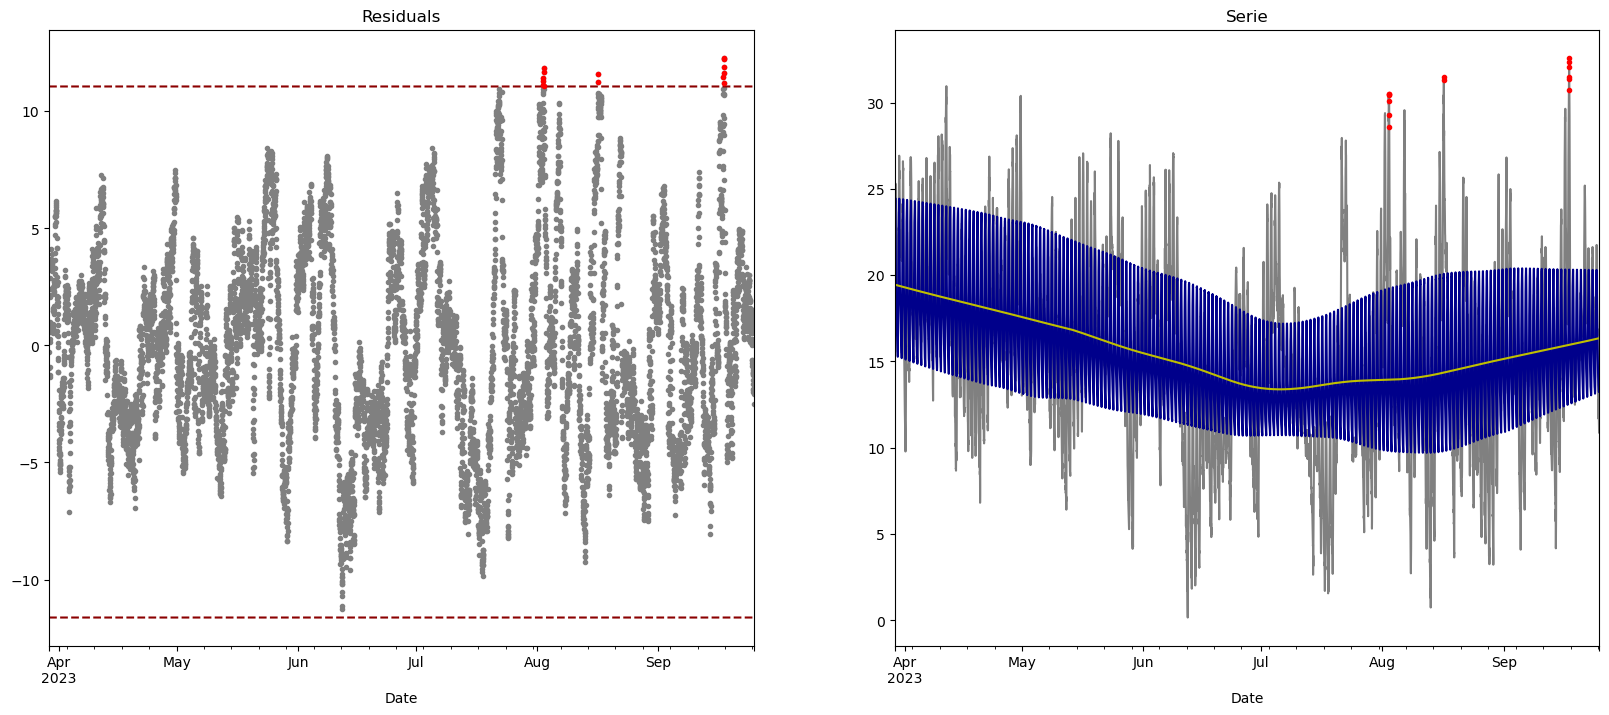

In [14]:
# Outliers in Temperature series and residuals plot
# Highlighted in red on each one
fig, ax = plt.subplots(ncols = 2, figsize = (20, 8))

w_outliers.resid.plot(marker = '.', color = 'gray', linestyle = '', ax = ax[0])
w_outliers[['upper', 'lower']].plot(linestyle = '--', color = 'darkred', legend = False, ax = ax[0])

w_outliers.Temperature.plot(color = 'gray', ax = ax[1])
w_outliers.seasons_trend.plot(color = 'darkblue', ax = ax[1])
dec.trend.plot(color = 'y', ax = ax[1])


if w_outliers.is_outlier.any():
    w_outliers.loc[w_outliers.is_outlier].resid.plot(marker = '.', color = 'red', linestyle = '', ax = ax[0])
    w_outliers.loc[w_outliers.is_outlier].Temperature.plot(marker = '.', color = 'red', linestyle = '', ax = ax[1])

ax[0].set_title('Residuals')
ax[1].set_title('Serie')

plt.show()

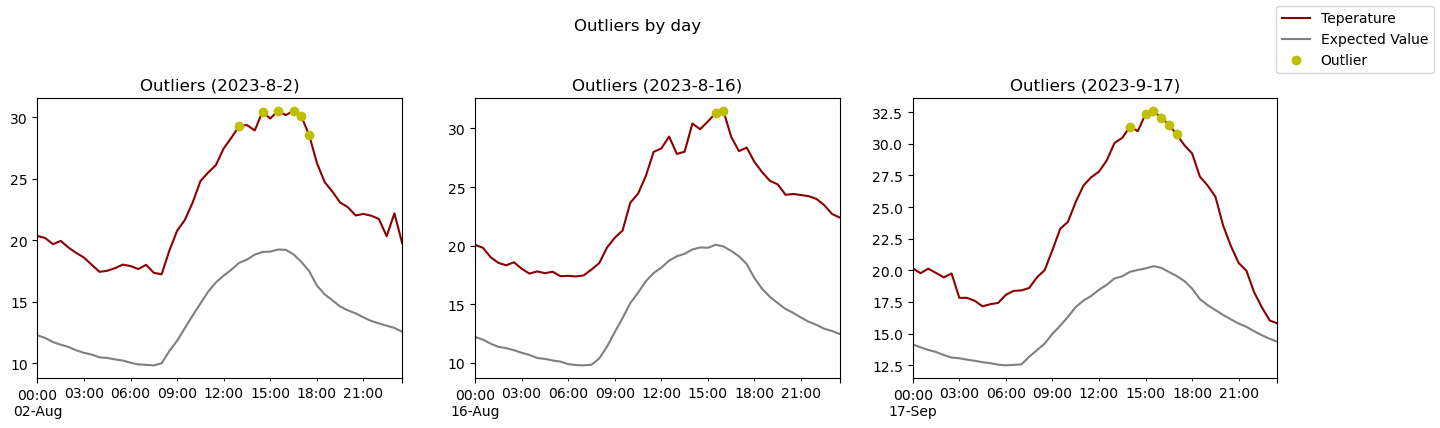

In [15]:
# Outliers by date
dates = (w_outliers
 .loc[w_outliers.is_outlier]
 .pivot_table(index = pd.Grouper(freq = 'D'), values = 'is_outlier', aggfunc = 'max', dropna = True)
 .index
)

fig, ax = plt.subplots(nrows = 2, ncols = 3)

for i, ix in enumerate(ax.flatten()):
    
    if i+1 > len(dates): 
        ix.remove()
        continue
    
    mask = f'{dates[i].year}-{dates[i].month}-{dates[i].day}'
    (w_outliers
     .loc[mask]
     .plot(y = ['Temperature', 'seasons_trend'], color = ['darkred', 'gray'], legend = False, figsize = (16, 8), ax = ix))
    
    (w_outliers
     .loc[w_outliers.is_outlier]
     .loc[mask].Temperature
     .plot(linestyle = '', marker = 'o', color = 'y', legend = False, ax = ix))
    
    ix.set_xlabel('')
    ix.set_title(f'Outliers ({mask})')

fig.legend(['Teperature', 'Expected Value', 'Outlier'])
fig.suptitle('Outliers by day')

plt.show()

<a name = '3'></a>
# 3. Feature engineering

<a name = '3.1'></a>
## 3.1 Trend changepoints

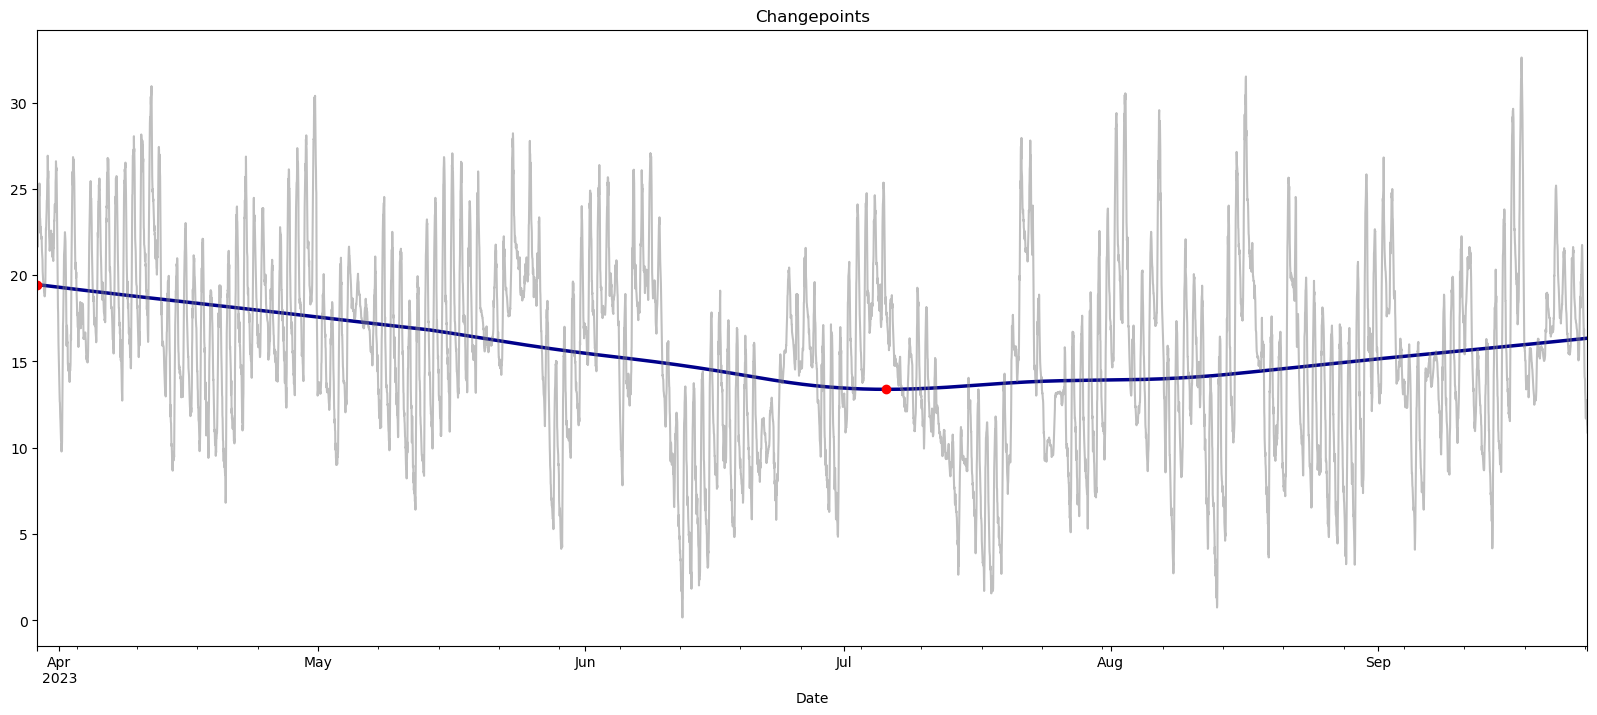

In [16]:
# Plotting trend and his changepoints
ax = w_outliers.trend.plot(color = 'darkblue', linewidth = 2.5, figsize = (20, 8))
w_outliers.Temperature.plot(color = 'gray', alpha = 0.5, ax = ax)
w_outliers.loc[w_outliers.changepoint].trend.plot(linestyle = '', marker = 'o', color = 'r', ax = ax);

plt.title('Changepoints')
plt.show()

<a name = '3.2'></a>
## 3.2 Lag Features

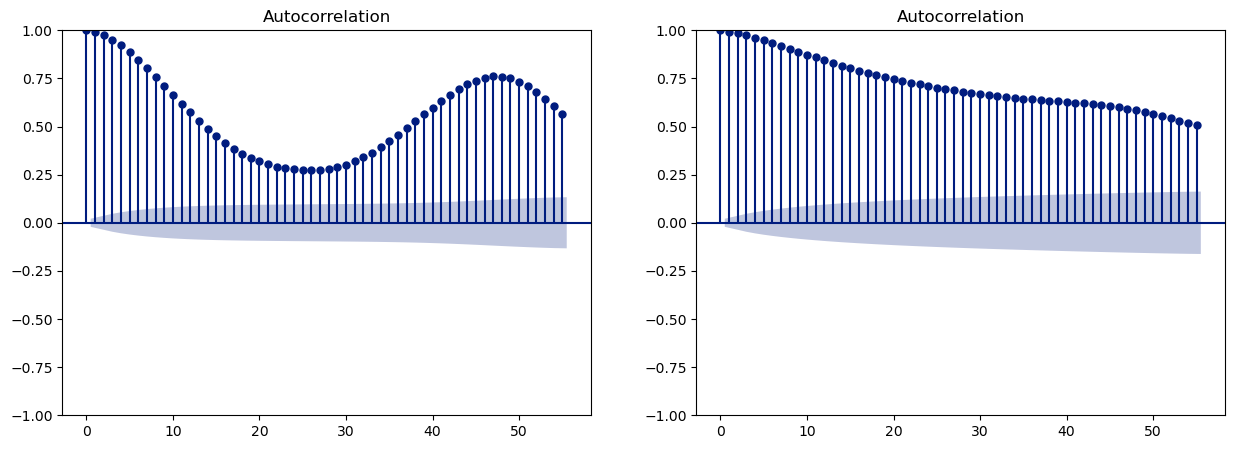

In [17]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
plot_acf(w_outliers.Temperature, lags = 55, ax = ax[0]);
plot_acf(w_outliers.resid, lags = 55, ax = ax[1]);


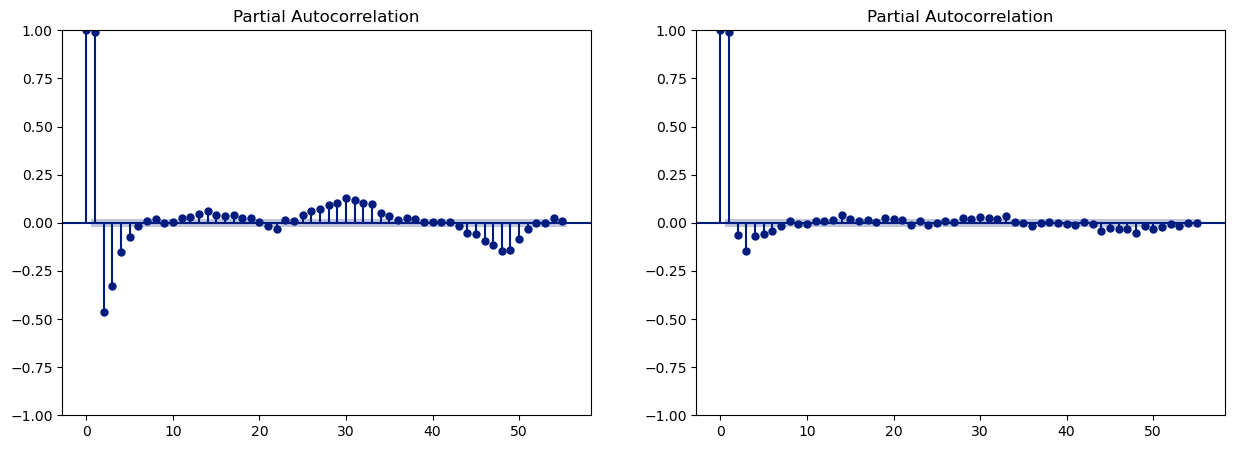

In [18]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
plot_pacf(w_outliers.Temperature, lags = 55, ax = ax[0], method = 'ywmle');
plot_pacf(w_outliers.resid, lags = 55, ax = ax[1], method = 'ywmle');

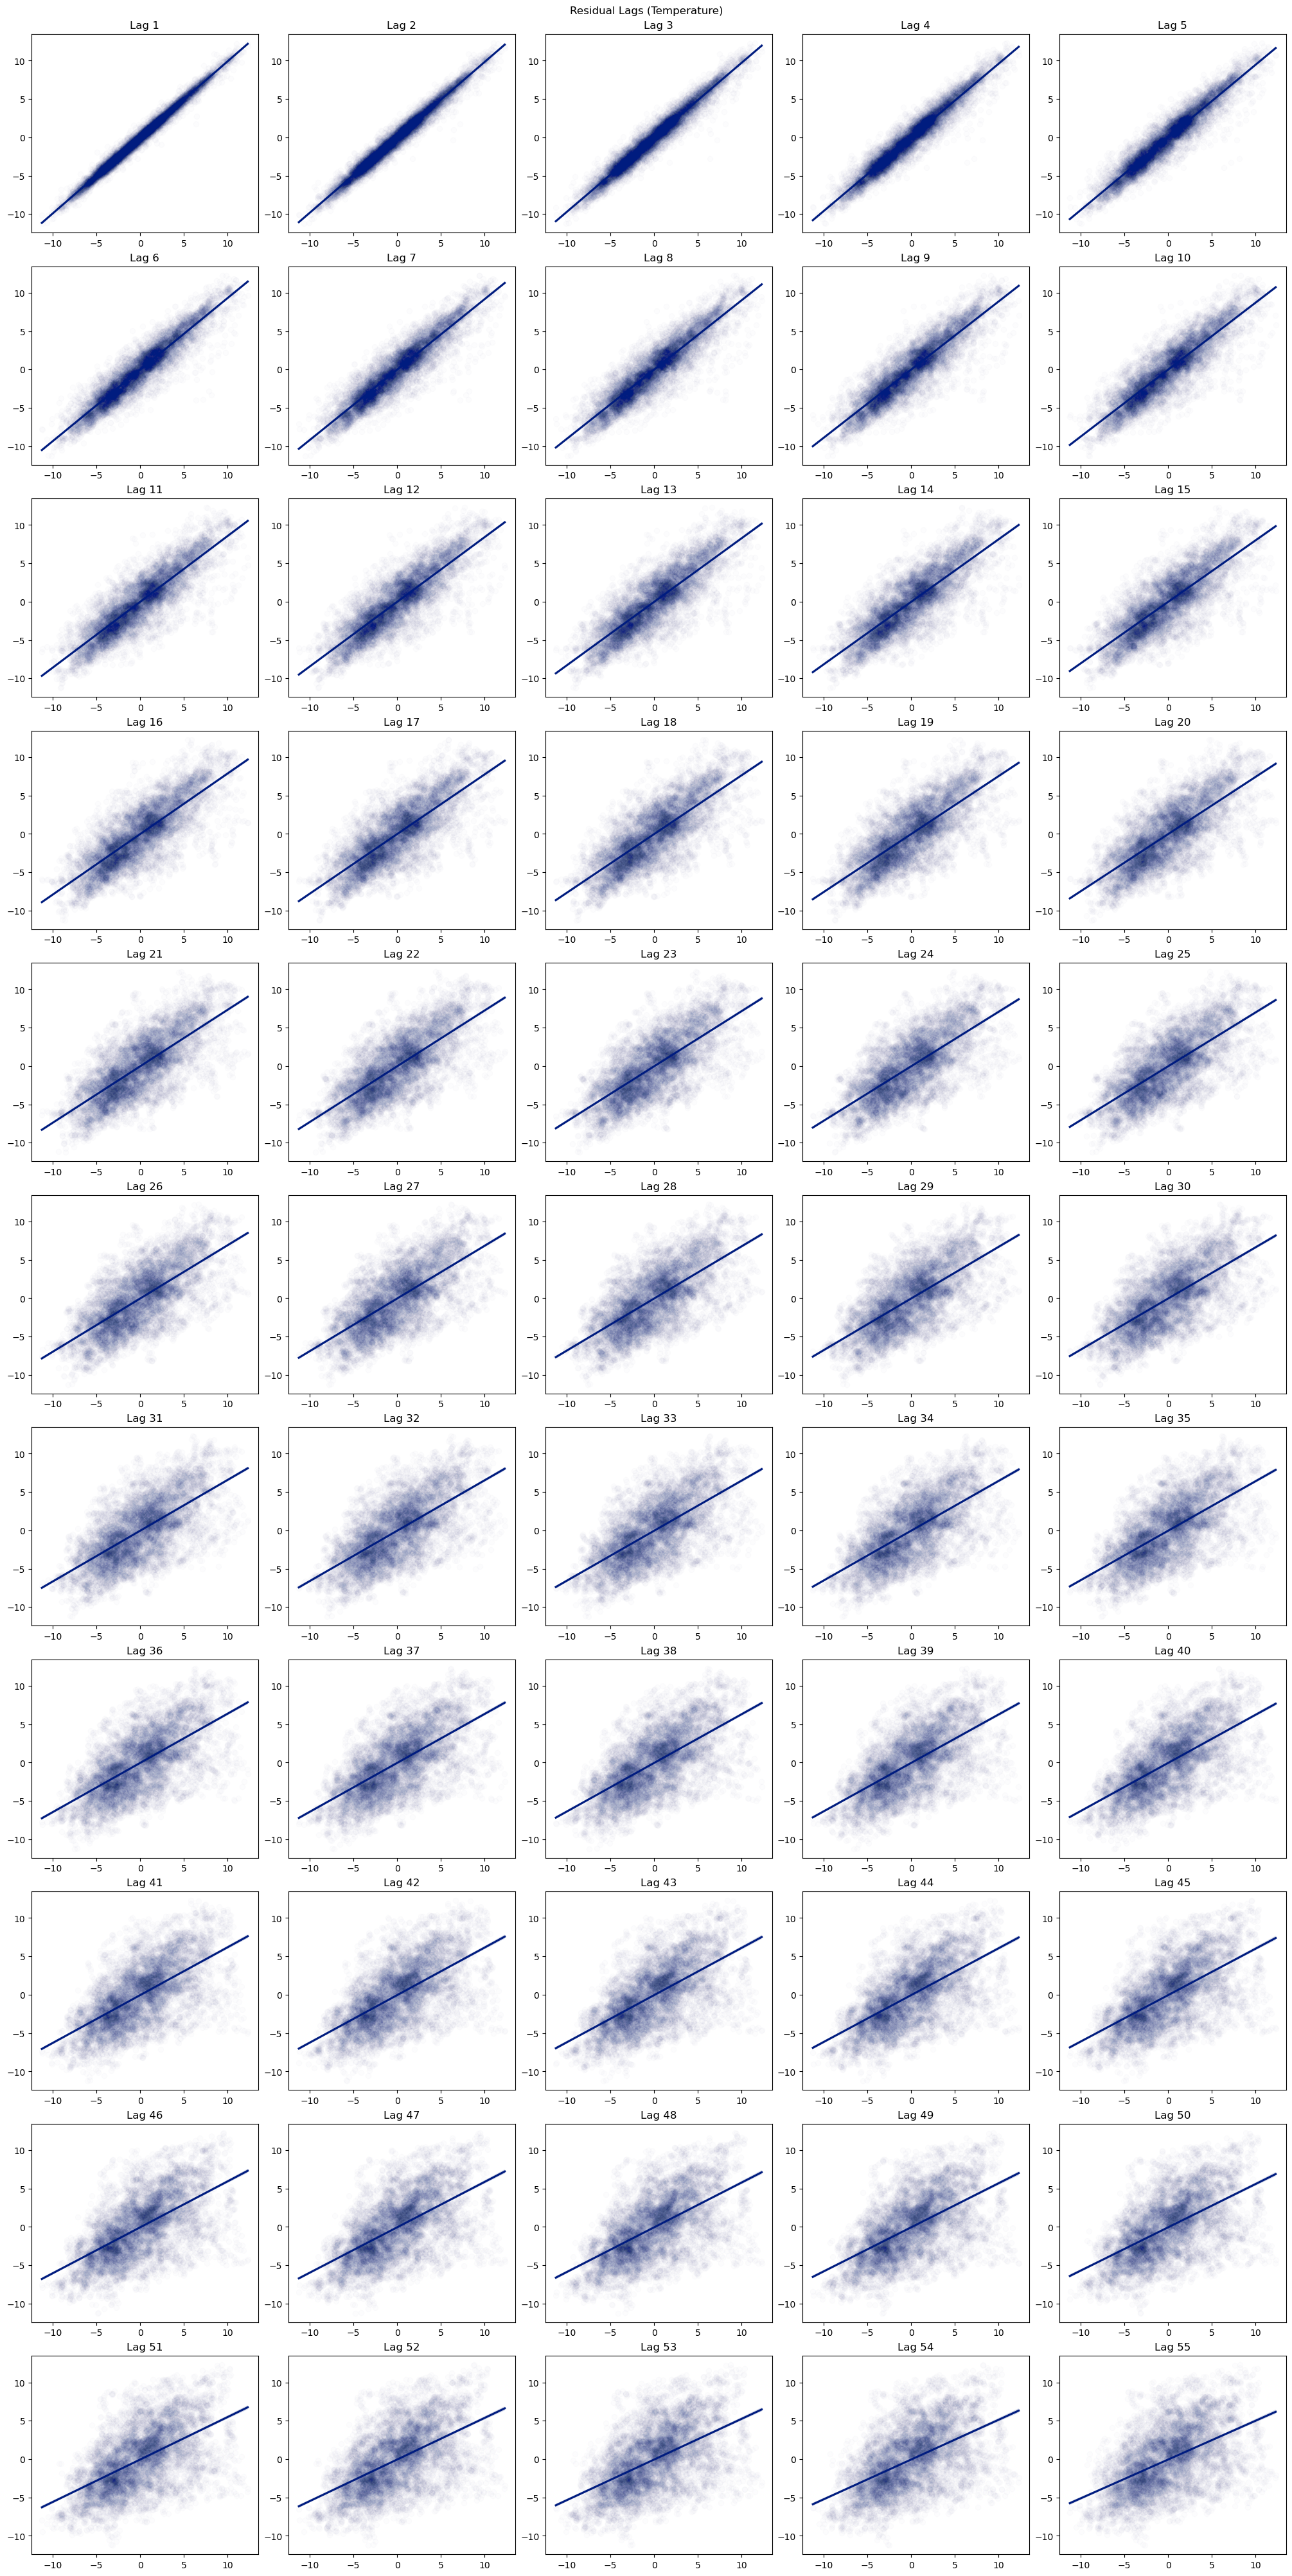

In [19]:
fig, ax = plt.subplots(nrows = 11, ncols = 5, figsize = (20, 40), layout = 'constrained')

for i, ix in enumerate(ax.flatten()):
    
    sns.regplot(x = w_outliers.resid.shift(i+1), y = w_outliers.resid, scatter_kws = {'alpha' : 0.01}, ax = ix)
    ix.set_xlabel('')
    ix.set_title(f'Lag {i+1}')
    ix.set_xlabel('')
    ix.set_ylabel('')

fig.suptitle('Residual Lags (Temperature)')

plt.show()

<a name = '4'></a>
# 4. Forecasting Model

<a name = '4.1'></a>
## 4.1 Pipeline

In [20]:
# Seasonal features
seasonal_ft = FourierFeatures(
    sp_list = [48],
    fourier_terms_list = [3],
    freq = '30min',
    keep_original_columns = False,
)

# Lag features
lag_ft = WindowSummarizer(
    target_cols = ['Temperature'],
    lag_feature = {
    'lag' : [1, 14, 22, 33],
    'std' : [[1, 5], [1, 14], [1, 22]],
    },
    truncate = 'ffill',
)


In [21]:
pipeline = make_union(
    lag_ft,
    seasonal_ft,
)

pipeline = make_pipeline(
    pipeline,
    Imputer(method = 'constant', value = 0),
    MinMaxScaler(),
)

pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 14, 22, 33],
                              'std': [[1, 5], [1, 14], [1, 22]]},
                 target_cols=['Temperature'], truncate='ffill')),
                                                ('fourierfeatures',
                                                 FourierFeatures(fourier_terms_list=[3], freq='30min', sp_list=[48]))])),
                ('imputer', Imputer(method='constant', value=0)),
                ('minmaxscaler', MinMaxScaler())])

<a name = '4.2'></a>
## 4.2 Linear Regression

In [22]:
def naive_performance(df):
    '''
    Computes time series basic level performance thru Naive forecast approach
    df: Weather dataframe with datetime index and temperature column
    
    Output:
    Prints Naive forecast performance on train and test set
    '''
    df = df.assign(predictions = df.Temperature.shift(1).fillna(method = 'bfill'))
    
    train = df.loc[:'2023-08-31']
    test = df.loc['2023-09-01':]
    
    rmse_train = mean_squared_error(train.Temperature, train.predictions,squared = False)
    rmse_test = mean_squared_error(test.Temperature, test.predictions, squared = False)
    
    return print(f'RMSE - Naive forecast performance: \n- Train set: {rmse_train}\n- Test set: {rmse_test}')


naive_performance(weather)

RMSE - Naive forecast performance: 
- Train set: 0.7035920903674553
- Test set: 0.5927671012568735


In [23]:
# Train/Test split
weather = weather[['Temperature']]

train = weather.loc[weather.index < '2023-09-01'].copy()
test = weather.loc[weather.index >= '2023-08-31'].copy()

x_train = pipeline.fit_transform(train[['Temperature']])
y_train = train[['Temperature']]

x_test = test[['Temperature']]
y_test = test[['Temperature']]

In [24]:
# Linear regression fit and performance
model = LinearRegression()
model.fit(x_train, y_train)

rmse_train = mean_squared_error(y_train, model.predict(x_train), squared = False)
rmse_test = mean_squared_error(y_test.loc['2023-09-01':]
                               , model.predict(pipeline.transform(x_test.copy()))[48:]
                               , squared = False)

print(f'RMSE - model performance: \n- Train set: {rmse_train}\n- Test set: {rmse_test}')

RMSE - model performance: 
- Train set: 0.6386025929312901
- Test set: 0.4785670704891603


<a name = '4.3'></a>
## 4.3 Recursive forecasting

In [25]:
# Creating forecasting horizon
f_horizon = pd.date_range(start = x_test.index.max() + pd.DateOffset(minute = 30), 
                          # change the value of n on offsets.Day(n) to set the desired forecasting horizon
                          end = x_test.index.max() + pd.offsets.Day(2), freq = '30min') 

# Joining test set and forecasting horizon
df_predict = pd.concat([x_test, pd.DataFrame(index = f_horizon)]).assign(Predictions = np.nan, test_temp = lambda df_: df_.Temperature)
na_dates = [str(x) for x in df_predict.loc[df_predict.Temperature.isna()].index] # to validate forecasting values outside the test set

# Recursive forecasting
for time in df_predict.index:
        
    x_text_temp = pipeline.transform(df_predict.loc[time - pd.offsets.Day(1) :time][['Temperature']])
    f_point = x_text_temp.loc[[time]]
    
    pred = model.predict(f_point)
    df_predict.loc[time, 'Predictions'] = pred[0]
    
    if df_predict.loc[[time]].index in na_dates:
        df_predict.loc[time,'Temperature'] = pred[0]


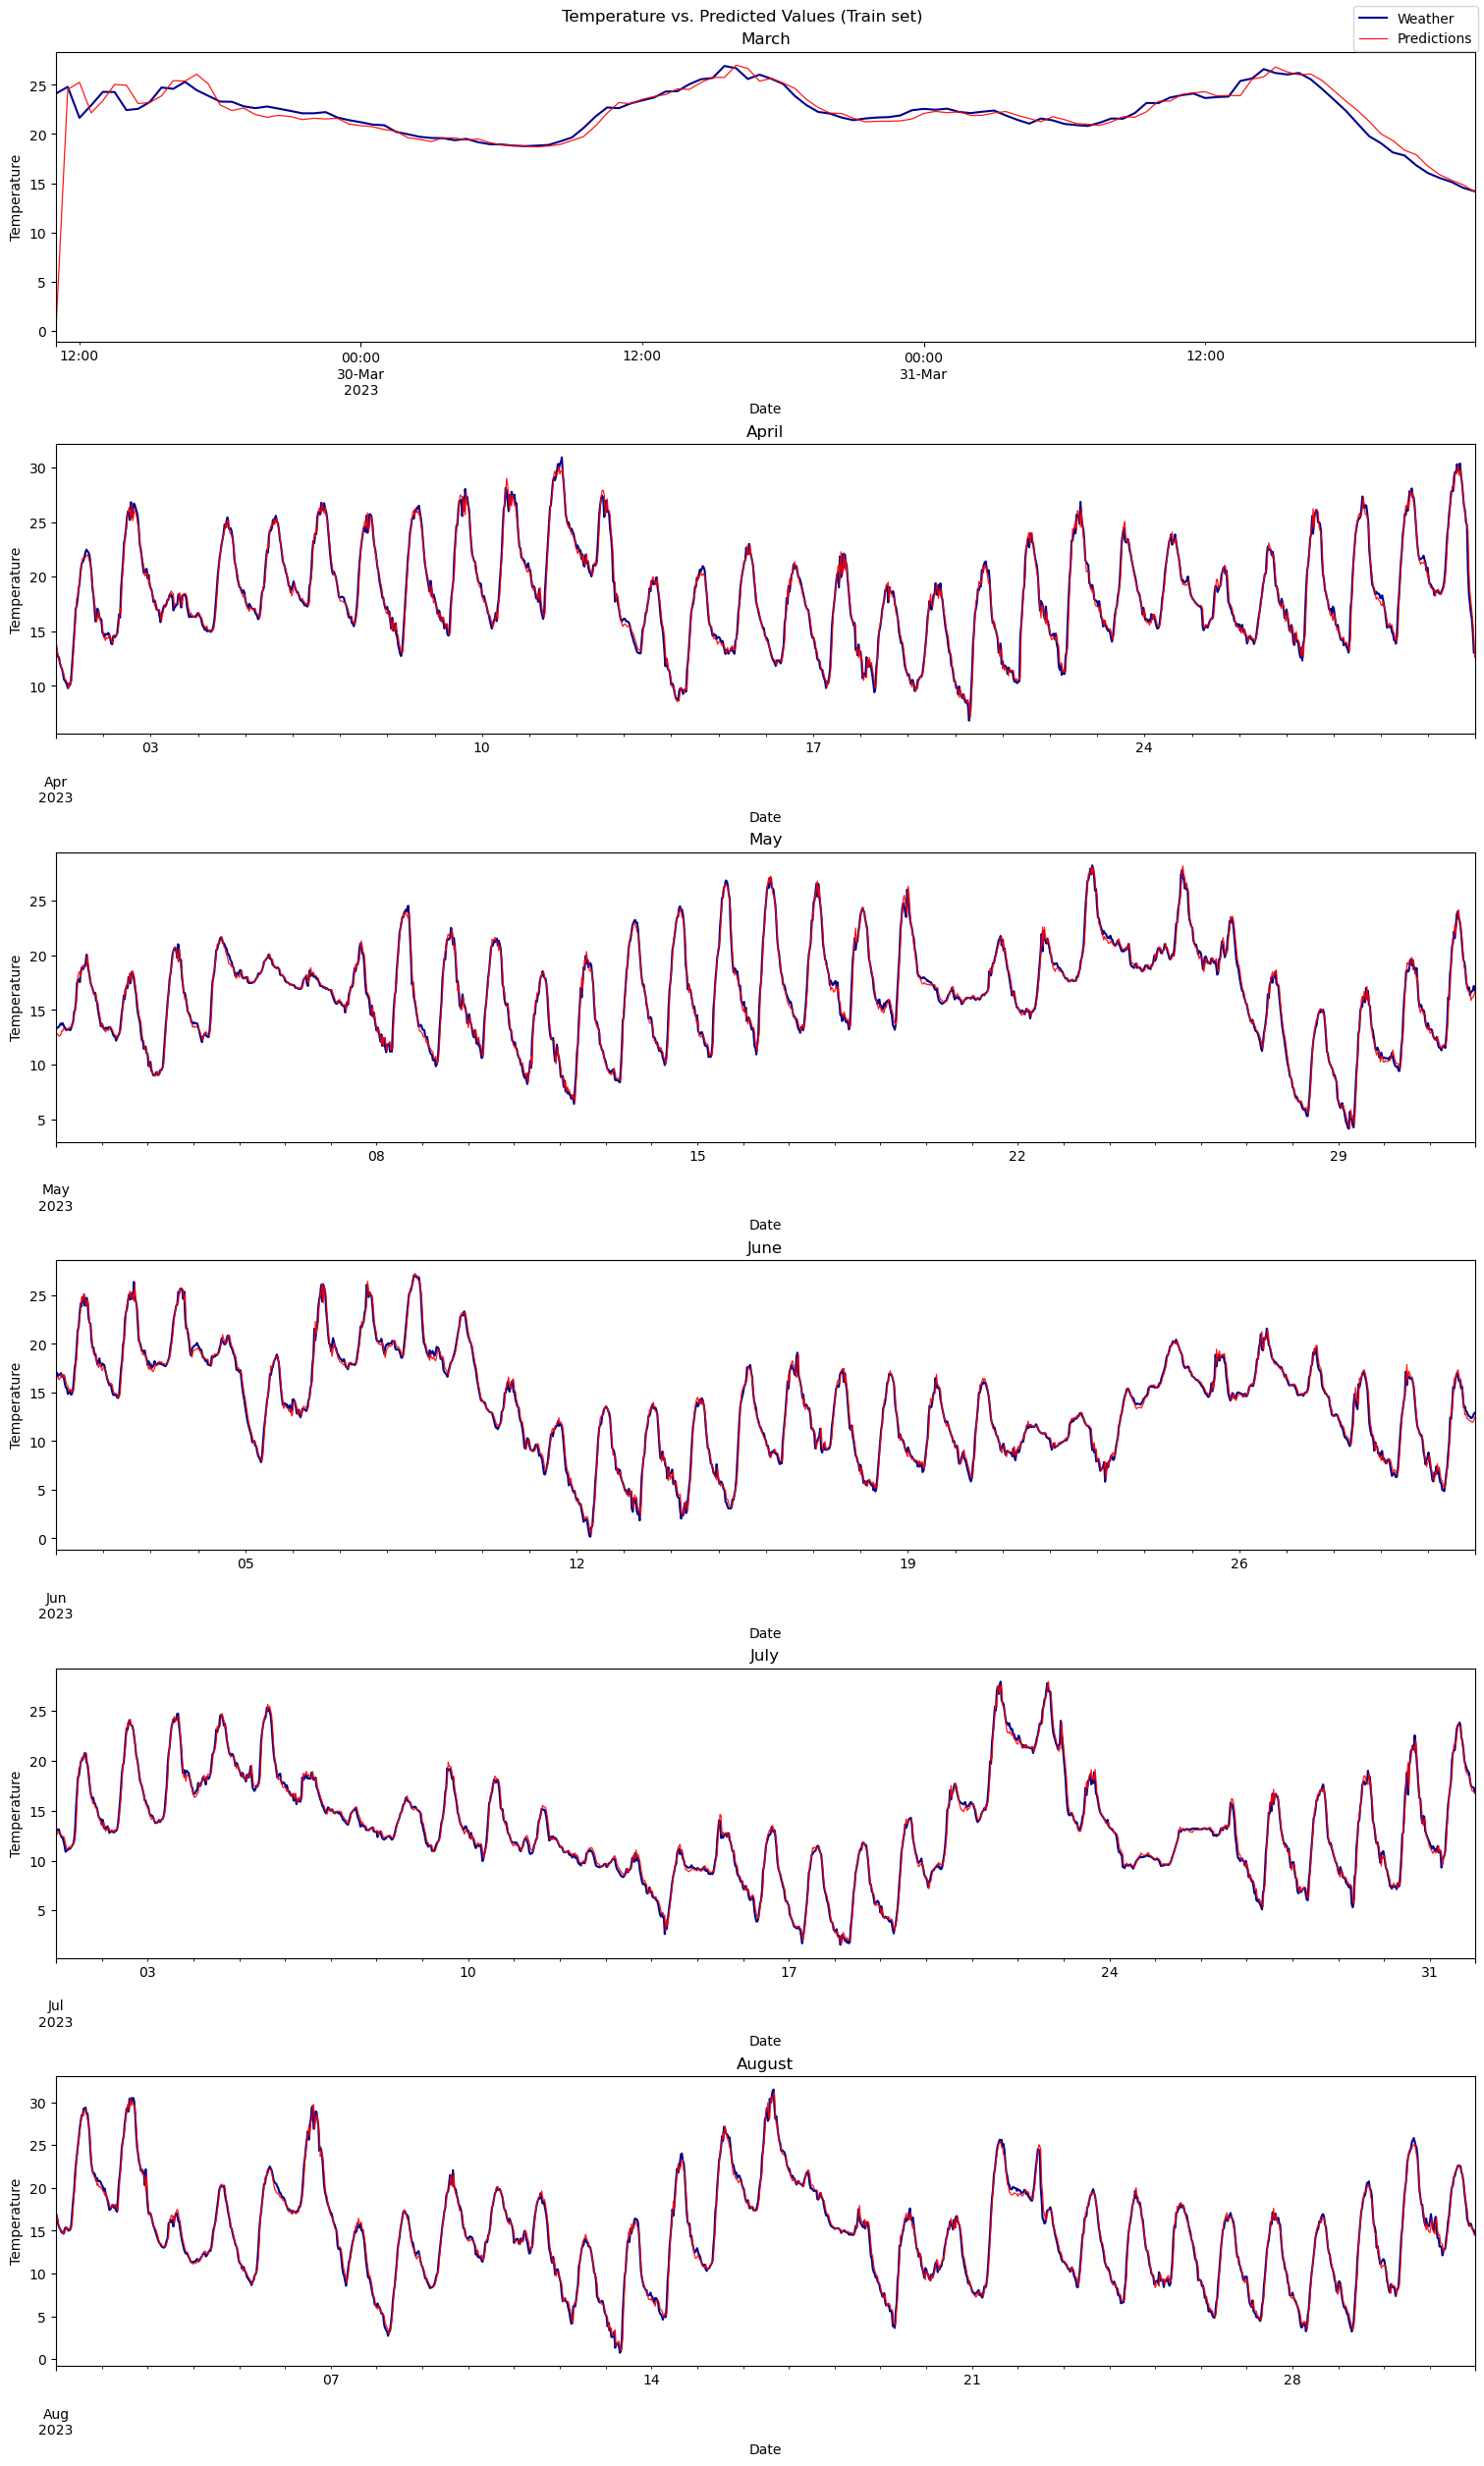

In [26]:
# Plotting train set temperature vs model predictions 
fig, ax = plt.subplots(nrows = 6, figsize = (15, 25), layout = 'constrained') 

train = (train.assign(Predictions = model.predict(x_train)))
months = ['March', 'April', 'May', 'June', 'July', 'August']
months_ = train.index.month.unique()

for i, ix in enumerate(ax.flatten()):
    train.loc[train.index.month == months_[i]].Temperature.plot(color = 'darkblue', ax = ix)
    train.loc[train.index.month == months_[i]].Predictions.plot(color = 'r', linewidth = 0.9, alpha = 0.9, ax = ix)

    ix.set_ylabel('Temperature')
    ix.set_title(months[i])

fig.legend(['Weather', 'Predictions'], loc = 'upper right')
fig.suptitle('Temperature vs. Predicted Values (Train set)')
plt.show()

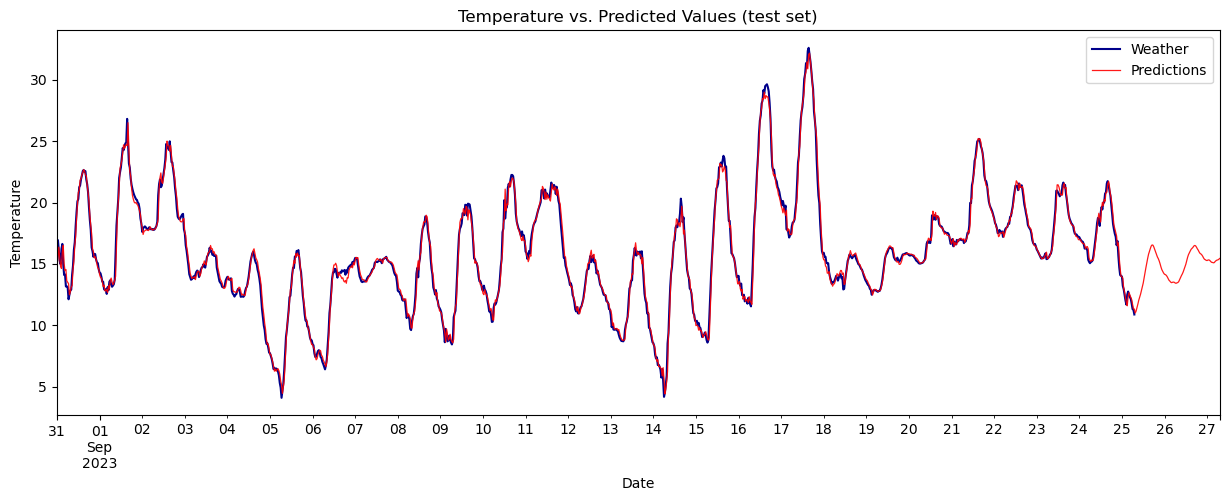

In [27]:
# Plotting test set temperature vs model predictions and forecasting horizon values
# (window = n days ** take a look at the recursive forecasting cell -- 2 cells above)
fig, ax = plt.subplots(figsize = (15, 5))

df_predict.test_temp.plot(color = 'darkblue', ax = ax)
df_predict.Predictions.plot(color = 'r', linewidth = 0.9, alpha = 0.9, ax = ax)

plt.legend(['Weather', 'Predictions'])
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature vs. Predicted Values (test set)')

plt.show()